## 1. Data source: Sleep-Accel (PhysioNet; Apple Watch + PSG)

**Dataset:** *Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography* (PhysioNet, v1.0.0)

- **PhysioNet dataset page (download + description):**   
    - https://physionet.org/content/sleep-accel/1.0.0/   
- **DOI (v1.0.0):**   
    - https://doi.org/10.13026/hmhs-py35   
- **Local path (expected):** download + unzip into `./data/sleep_accel/` (the `data/` directory is not committed to git)   
    - expected: `heart_rate/`, `motion/`, `labels/`, `steps/`, plus `LICENSE.txt`   
- **License (for files):** Open Data Commons Attribution License v1.0 (**ODC-By 1.0**)   

**Citations (as requested by PhysioNet):**   
- Walch, O. (2019). *Motion and heart rate from a wrist-worn wearable and labeled sleep from polysomnography* (version 1.0.0). PhysioNet. https://doi.org/10.13026/hmhs-py35   
- Walch, O., Huang, Y., Forger, D., Goldstein, C. (2019). *Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device*. SLEEP. https://doi.org/10.1093/sleep/zsz180   
- Goldberger, A. L., et al. (2000). *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*. Circulation.   


**Files used(and expected columns)**   

We will use the following folders/files from the PhysioNet release:   

- **Motion (ACC):** `motion/[subject]_acceleration.txt`  
  Columns per line: `t_sec, ax_g, ay_g, az_g`  
  where `t_sec` is seconds since PSG start, and accelerations are in **g**.   

- **Heart rate (HR):** `heart_rate/[subject]_heartrate.txt`  
  Columns per line: `t_sec, hr_bpm`  
  where `hr_bpm` is heart rate in **beats per minute**.   

- **PSG sleep labels:** `labels/[subject]_labeled_sleep.txt`  
  Columns per line: `t_sec, stage` with stage codes:  
  `Wake=0, N1=1, N2=2, N3=3, REM=5` (we drop unscored/invalid epochs if present).

> Note: The dataset also includes `steps/` files, but we won’t use them in the first version.


**Notebook intention**

Goal: build a **reproducible sleep-staging pipeline** from **wrist ACC + HR** aligned to **PSG-scored 30-second epochs**, with **leakage-aware, subject-wise evaluation**.

What we do:   

1. **Define the modeling unit as the PSG epoch (30s)** and build one feature row per epoch.  
2. **Align** wrist **ACC** and **HR** to each labeled 30s epoch (aggregate samples falling in `[t, t+30s)`), and attach the PSG stage label at `t`.  
3. **Extract simple, readable features** per epoch:   
   - ACC: magnitude and axis statistics + activity intensity proxies  
   - HR: summary statistics + missingness indicators  
4. Add **causal context (history) features** using past-only rolling summaries over recent epochs (e.g., last few minutes) to capture local sleep continuity without using future information.  
5. Train and compare a small set of classical models using **subject-wise cross-validation** (GroupKFold) and report robust staging metrics (macro-F1, balanced accuracy, confusion matrices, per-subject performance).  
6. Apply a lightweight **temporal stabilization** step (e.g., hysteresis / causal smoothing of probabilities) to reduce one-epoch “blips” and reflect product-realistic output stability.

Note on extra “pre-PSG” wearable data:

This dataset includes wearable streams that may start **before PSG time zero** (e.g., steps for days prior, HR for hours prior, motion shortly before). For the main staging pipeline we **restrict to the PSG-labeled interval** and only aggregate sensor data within labeled 30s epochs. Pre-PSG data can be used in extensions as **subject-level context** (e.g., prior-days activity summaries computed strictly from `t < 0`), but coverage varies across subjects and adds preprocessing complexity.


## 2. Data loading and check

We load per-subject **wrist accelerometer (ACC)**, **heart rate (HR)**, and **PSG sleep labels** from the PhysioNet Sleep-Accel folder structure.

Key conventions:
- All timestamps are de-identified and expressed as **seconds since PSG start** (`t=0` is the PSG start time).
- For the main staging pipeline, we **restrict to the PSG-labeled interval** and only aggregate sensor samples that fall inside each labeled 30s epoch.


In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd

STAGE_MAP = {
    0: "Wake",
    1: "N1",
    2: "N2",
    3: "N3",
    5: "REM",
}

# --- Paths ---
DATA_DIR   = Path("../data/sleep_accel")
MOTION_DIR = DATA_DIR / "motion"
HR_DIR     = DATA_DIR / "heart_rate"
LABEL_DIR  = DATA_DIR / "labels"

for d in [DATA_DIR, MOTION_DIR, HR_DIR, LABEL_DIR]:
    assert d.exists(), f"Missing: {d}"

# --- Subject discovery (use labels as the "source of truth") ---
label_files = sorted(LABEL_DIR.glob("*_labeled_sleep.txt"))
assert len(label_files) > 0, f"No label files found in: {LABEL_DIR}"

SUBJECT_IDS = [re.match(r"(\d+)_labeled_sleep\.txt", f.name).group(1) for f in label_files]
print(f"Found {len(SUBJECT_IDS)} subjects (from labels/). Example IDs: {SUBJECT_IDS[:5]}")

# --- Loaders ---
def load_labels(subject_id: str) -> pd.DataFrame:
    """Load PSG sleep labels: columns [t_sec, stage]."""
    path = LABEL_DIR / f"{subject_id}_labeled_sleep.txt"
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["t_sec", "stage"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    df["stage"] = df["stage"].astype(int)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

def load_hr(subject_id: str) -> pd.DataFrame:
    """Load Apple Watch HR: columns [t_sec, hr_bpm]."""
    path = HR_DIR / f"{subject_id}_heartrate.txt"
    df = pd.read_csv(path, sep=",", header=None, names=["t_sec", "hr_bpm"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    df["hr_bpm"] = df["hr_bpm"].astype(float)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

def load_acc(subject_id: str) -> pd.DataFrame:
    """Load Apple Watch accelerometer: columns [t_sec, ax_g, ay_g, az_g]."""
    path = MOTION_DIR / f"{subject_id}_acceleration.txt"
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["t_sec", "ax_g", "ay_g", "az_g"])
    df["subject_id"] = subject_id
    df["t_sec"] = df["t_sec"].astype(float)
    for c in ["ax_g", "ay_g", "az_g"]:
        df[c] = df[c].astype(float)
    df = df.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
    return df

# --- Load ALL subjects---
def load_all(subject_ids, loader_fn):
    return pd.concat([loader_fn(sid) for sid in subject_ids], ignore_index=True)

labels = load_all(SUBJECT_IDS, load_labels)
hr     = load_all(SUBJECT_IDS, load_hr)
acc    = load_all(SUBJECT_IDS, load_acc)

print("\nLoaded ALL data:")
print(f"  labels: {labels.shape} | subjects={labels['subject_id'].nunique()}")
print(f"  hr    : {hr.shape}     | subjects={hr['subject_id'].nunique()}")
print(f"  acc   : {acc.shape}    | subjects={acc['subject_id'].nunique()}")

# --- Quick sanity check on one subject (example only) ---
sid = SUBJECT_IDS[0]

labels_ex = labels[labels["subject_id"] == sid].copy()
hr_ex     = hr[hr["subject_id"] == sid].copy()
acc_ex    = acc[acc["subject_id"] == sid].copy()

print(f"\nExample subject {sid}:")
print(f"  labels_ex: {labels_ex.shape} | t range: [{labels_ex.t_sec.min():.1f}, {labels_ex.t_sec.max():.1f}]")
print(f"  hr_ex    : {hr_ex.shape}     | t range: [{hr_ex.t_sec.min():.1f}, {hr_ex.t_sec.max():.1f}]")
print(f"  acc_ex   : {acc_ex.shape}    | t range: [{acc_ex.t_sec.min():.1f}, {acc_ex.t_sec.max():.1f}]")

label_counts = labels_ex["stage"].value_counts().sort_index()
display(pd.DataFrame({
    "stage_code": label_counts.index,
    "stage_name": [STAGE_MAP.get(int(s), "OTHER") for s in label_counts.index],
    "count": label_counts.values,
}))


Found 31 subjects (from labels/). Example IDs: ['1066528', '1360686', '1449548', '1455390', '1818471']

Loaded ALL data:
  labels: (27211, 3) | subjects=31
  hr    : (254425, 3)     | subjects=31
  acc   : (51819151, 5)    | subjects=31

Example subject 1066528:
  labels_ex: (952, 3) | t range: [0.0, 28530.0]
  hr_ex    : (16617, 3)     | t range: [-355241.7, 34491.2]
  acc_ex   : (1281000, 5)    | t range: [-21684.8, 28626.5]


,stage_code,stage_name,count
0,0,Wake,185
1,1,N1,97
2,2,N2,299
3,3,N3,62
4,5,REM,309


## 3. Epoch alignment (30s) — assign raw samples to PSG epochs

We use PSG labels as the **epoch grid** (30s cadence), and assign raw HR and ACC samples to each epoch.

Output: one row per epoch with:  
- `epoch_id`, `t_start_sec`, `t_end_sec`, `stage_code`  
- raw per-epoch sequences: HR (`t_sec`, `hr_bpm`) and ACC (`t_sec`, `ax_g`, `ay_g`, `az_g`)  

**Note on sampling rates and interpolation:**  
ACC is high-rate, HR is sparse/irregular, and labels are per 30s epoch. We **do not resample or interpolate** signals to a common grid. Instead, we compute **per-epoch summary features** (e.g. counts, mean/std/percentiles, simple trends) directly from the raw samples assigned to each epoch at the next section.

In [2]:
EPOCH_SEC = 30

# --- sort for safety (merge_asof requires sorted keys) ---
labels_s = labels.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
hr_s     = hr.sort_values("t_sec", kind="mergesort").reset_index(drop=True)
acc_s    = acc.sort_values("t_sec", kind="mergesort").reset_index(drop=True)

# --- epoch grid from labels (PSG epochs) ---
epochs = (
    labels_s.loc[labels_s["stage"].isin(STAGE_MAP.keys()), ["subject_id", "t_sec", "stage"]]
    .rename(columns={"t_sec": "t_start_sec", "stage": "stage_code"})
    .reset_index(drop=True)
)
epochs["t_end_sec"] = epochs["t_start_sec"] + EPOCH_SEC
epochs["epoch_id"] = epochs.index.astype(int)

# --- HR: assign each sample to the latest epoch start (backward), then keep only within [start, end) ---
hr_join = pd.merge_asof(
    hr_s, epochs[["subject_id", "t_start_sec", "t_end_sec", "epoch_id"]],
    left_on="t_sec", right_on="t_start_sec",
    by="subject_id",
    direction="backward",
)
# Keep only samples that truly fall inside the assigned epoch window [t_start, t_end)
hr_join = hr_join[hr_join["t_sec"] < hr_join["t_end_sec"]]

hr_raw = (
    hr_join.groupby(["subject_id", "epoch_id"], sort=True)[["t_sec", "hr_bpm"]]
    .apply(lambda g: pd.Series({
        "hr_t_sec": g["t_sec"].to_numpy(),
        "hr_bpm":  g["hr_bpm"].to_numpy(),
    }))
    .reset_index()
)

# --- ACC: same assignment ---
acc_join = pd.merge_asof(
    acc_s, epochs[["subject_id", "t_start_sec", "t_end_sec", "epoch_id"]],
    left_on="t_sec", right_on="t_start_sec",
    by="subject_id",
    direction="backward",
)
acc_join = acc_join[acc_join["t_sec"] < acc_join["t_end_sec"]]

acc_raw = (
    acc_join.groupby(["subject_id", "epoch_id"], sort=True)[["t_sec", "ax_g", "ay_g", "az_g"]]
    .apply(lambda g: pd.Series({
        "acc_t_sec": g["t_sec"].to_numpy(),
        "acc_x":     g["ax_g"].to_numpy(),
        "acc_y":     g["ay_g"].to_numpy(),
        "acc_z":     g["az_g"].to_numpy(),
    }))
    .reset_index()
)

# --- epoch table with raw sequences (no features yet) ---
epoch_raw = (
    epochs.merge(hr_raw, on=["subject_id", "epoch_id"], how="left")
          .merge(acc_raw, on=["subject_id", "epoch_id"], how="left")
)

print("epoch_raw:", epoch_raw.shape)
display(epoch_raw.head())


epoch_raw: (26417, 11)


,subject_id,t_start_sec,stage_code,t_end_sec,epoch_id,hr_t_sec,hr_bpm,acc_t_sec,acc_x,acc_y,acc_z
0,1066528,0.0,0,30.0,0,"[6.38561010361, 6.38561010361, 6.38561010361, ...","[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 51.0, 51....","[0.0159480571747, 0.0360059738159, 0.055885076...","[0.4039307, 0.4039154, 0.4049072, 0.4083557, 0...","[0.4490051, 0.4480286, 0.4465485, 0.447525, 0....","[-0.7968597, -0.7953949, -0.7958527, -0.796768..."
1,3509524,0.0,0,30.0,1,"[2.97270989418, 6.97270989418, 11.9727399349, ...","[82.0, 84.0, 86.0, 86.0, 86.0, 83.0, 76.0]","[0.00270414352417, 0.0179829597473, 0.03272795...","[0.0323334, 0.0274353, 0.02388, 0.0252228, 0.0...","[-0.4576111, -0.4629974, -0.4717712, -0.465408...","[-0.8885193, -0.8871613, -0.8794403, -0.874557..."
2,4018081,0.0,0,30.0,2,"[1.20449995995, 5.2044699192, 9.2044699192, 18...","[69.0, 66.0, 62.0, 57.0, 58.0, 61.0]","[0.0129339694977, 0.0286469459534, 0.042945861...","[-0.4547424, -0.4547424, -0.455246, -0.4581757...","[0.5541077, 0.5541077, 0.5560608, 0.5536194, 0...","[-0.6973724, -0.6978607, -0.6973877, -0.696945..."
3,4426783,0.0,0,30.0,3,"[3.28572010994, 7.28574991226, 13.2857499123, ...","[71.0, 71.0, 72.0, 61.0, 60.0, 60.0]","[0.0104320049286, 0.0303421020508, 0.050279140...","[-0.7835388, -0.7860413, -0.7800598, -0.783889...","[-0.21698, -0.2355804, -0.2243347, -0.2145691,...","[-0.5306091, -0.5212555, -0.5314789, -0.546798..."
4,5132496,0.0,0,30.0,4,"[6.48358011246, 8.48358011246, 12.4835801125, ...","[113.0, 115.0, 112.0, 117.0, 113.0]","[0.0128321647644, 0.0269389152527, 0.042412996...","[-0.1996918, -0.4198914, -0.3826447, -0.204345...","[0.3026581, 0.1375885, 0.0600433, 0.2941742, 0...","[-0.9453125, -0.8695831, -0.9243622, -0.813476..."


Example plot for one epoch: subject_id=759667 | epoch_id=756 | window=[1080.0,1110.0) | stage=N3


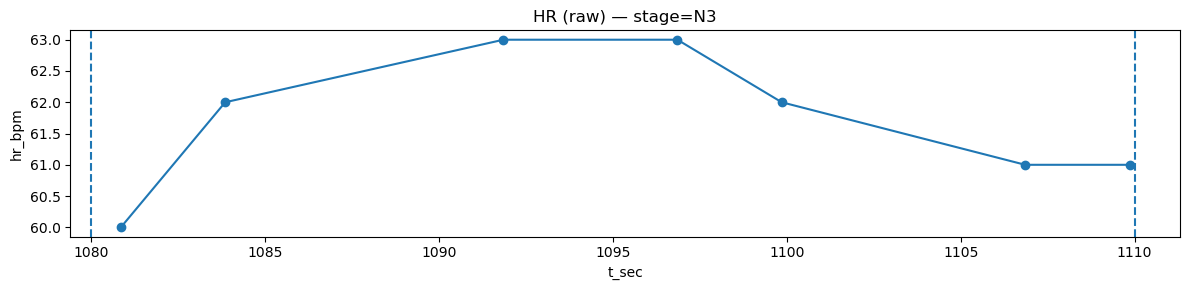

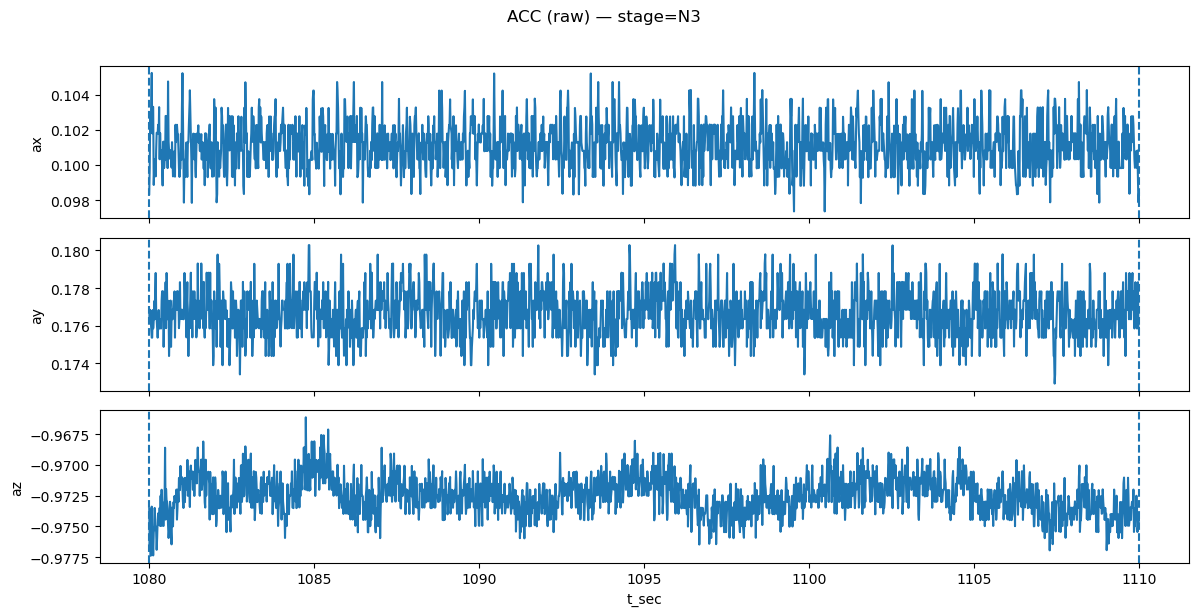

In [3]:
import matplotlib.pyplot as plt

# Choose a stage code to visualize:
# 0=Wake, 1=N1, 2=N2, 3=N3, 5=REM  (see STAGE_MAP)
TARGET_STAGE_CODE = 3

# First epoch (in the current subject) matching that stage
idx = epoch_raw.index[epoch_raw["stage_code"] == TARGET_STAGE_CODE][0]
row = epoch_raw.loc[idx]

t0, t1 = row["t_start_sec"], row["t_end_sec"]
print(f"Example plot for one epoch: subject_id={row['subject_id']} | epoch_id={int(row['epoch_id'])} | window=[{t0},{t1}) | stage={STAGE_MAP.get(int(row['stage_code']), row['stage_code'])}")

# HR (raw)
plt.figure(figsize=(12, 3))
if isinstance(row.get("hr_t_sec"), np.ndarray):
    plt.plot(row["hr_t_sec"], row["hr_bpm"], marker="o")
plt.axvline(t0, linestyle="--"); plt.axvline(t1, linestyle="--")
plt.title(f"HR (raw) — stage={STAGE_MAP.get(TARGET_STAGE_CODE, TARGET_STAGE_CODE)}")
plt.xlabel("t_sec"); plt.ylabel("hr_bpm")
plt.tight_layout()
plt.show()

# ACC (raw) — 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for ax, col, name in zip(axes, ["acc_x", "acc_y", "acc_z"], ["ax", "ay", "az"]):
    if isinstance(row.get("acc_t_sec"), np.ndarray):
        ax.plot(row["acc_t_sec"], row[col])
    ax.axvline(t0, linestyle="--"); ax.axvline(t1, linestyle="--")
    ax.set_ylabel(name)

axes[-1].set_xlabel("t_sec")
fig.suptitle(f"ACC (raw) — stage={STAGE_MAP.get(TARGET_STAGE_CODE, TARGET_STAGE_CODE)}", y=1.02)
plt.tight_layout()
plt.show()


## 4. Feature extraction

We convert each PSG-aligned 30-second epoch into a single feature vector.  
To keep the notebook **simple and robust** (and to avoid a “feature zoo”, especially once we add **causal history features**), we use a **small, standard set of summary statistics**.

**Signals and features**

**Accelerometer (ACC):**   
- We collapse tri-axial ACC into **magnitude** `|a| = sqrt(ax² + ay² + az²)`.   
- Per epoch we compute: `count`, `mean`, `std`, `median`, `IQR`, `p10`, `p90`, `min`, `max`
- Dynamic proxy `std(diff(|a|))` (often useful for “movement bursts”)

**Heart rate (HR):**   
- Per epoch we compute: `count`, `mean`, `std`, `IQR`, `min`, `max`

**Time**   
- `time_since_start_hours` (simple time context within the night)

**Note on sampling and reliability**
ACC is high-rate while HR is sparse/irregular; labels are per 30s epoch. We **do not resample or interpolate**.  
Summary statistics are computed directly from the raw samples assigned to each epoch, and `count` acts as a lightweight **signal reliability** indicator (few/no samples → less reliable features).


### 4.1 Minimal per-epoch feature summaries (ACC magnitude + HR)

In [4]:
# --- Start from the epoch table (one row per 30s PSG epoch) ---
epoch_features = epoch_raw[["subject_id", "epoch_id", "t_start_sec", "t_end_sec", "stage_code"]].copy()
epoch_features["time_since_start_hours"] = epoch_features["t_start_sec"] / 3600.0

# --- HR features (per-epoch arrays -> scalar summaries) ---
# hr_bpm is stored as an array in each row
# treat missing (NaN) as empty
# --- HR features (per-epoch arrays -> scalar summaries) ---
hr_mean  = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).mean()) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_std   = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).std(ddof=0)) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_iqr   = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).quantile(0.75) - pd.Series(a).quantile(0.25)) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_min   = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).min()) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_max   = epoch_raw["hr_bpm"].apply(lambda a: float(pd.Series(a).max()) if isinstance(a, np.ndarray) and a.size else np.nan)
hr_count = epoch_raw["hr_bpm"].apply(lambda a: int(a.size) if isinstance(a, np.ndarray) else 0)

epoch_features["hr_mean"]  = hr_mean
epoch_features["hr_std"]   = hr_std
epoch_features["hr_iqr"]   = hr_iqr
epoch_features["hr_min"]   = hr_min
epoch_features["hr_max"]   = hr_max
epoch_features["hr_count"] = hr_count


# --- ACC magnitude features (x/y/z arrays -> magnitude array -> scalar summaries) ---
# Compute magnitude per epoch, then summarize
acc_mag = epoch_raw.apply(
    lambda r: np.sqrt(r["acc_x"]**2 + r["acc_y"]**2 + r["acc_z"]**2)
    if isinstance(r["acc_x"], np.ndarray) else np.array([], dtype=float),
    axis=1
)
acc_mag_count = acc_mag.apply(lambda a: int(a.size) if isinstance(a, np.ndarray) else 0)
acc_mag_mean  = acc_mag.apply(lambda a: float(pd.Series(a).mean()) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_std   = acc_mag.apply(lambda a: float(pd.Series(a).std(ddof=0)) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_median = acc_mag.apply(lambda a: float(pd.Series(a).median()) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_iqr   = acc_mag.apply(lambda a: float(pd.Series(a).quantile(0.75) - pd.Series(a).quantile(0.25)) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_p10   = acc_mag.apply(lambda a: float(pd.Series(a).quantile(0.10)) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_p90   = acc_mag.apply(lambda a: float(pd.Series(a).quantile(0.90)) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_min   = acc_mag.apply(lambda a: float(pd.Series(a).min()) if isinstance(a, np.ndarray) and a.size else np.nan)
acc_mag_max   = acc_mag.apply(lambda a: float(pd.Series(a).max()) if isinstance(a, np.ndarray) and a.size else np.nan)

# dynamic proxy: variability of first differences; at least 2 data points per epoch
acc_mag_diff_std = acc_mag.apply(
    lambda a: float(pd.Series(np.diff(a)).std(ddof=0)) if isinstance(a, np.ndarray) and a.size >= 2 else np.nan
)

epoch_features["acc_mag_count"]  = acc_mag_count
epoch_features["acc_mag_mean"]   = acc_mag_mean
epoch_features["acc_mag_std"]    = acc_mag_std
epoch_features["acc_mag_median"] = acc_mag_median
epoch_features["acc_mag_iqr"]    = acc_mag_iqr
epoch_features["acc_mag_p10"]    = acc_mag_p10
epoch_features["acc_mag_p90"]    = acc_mag_p90
epoch_features["acc_mag_min"]    = acc_mag_min
epoch_features["acc_mag_max"]    = acc_mag_max
epoch_features["acc_mag_diff_std"] = acc_mag_diff_std


print("epoch_features shape:", epoch_features.shape)
display(epoch_features.head())


epoch_features shape: (26417, 22)


,subject_id,epoch_id,t_start_sec,t_end_sec,stage_code,time_since_start_hours,hr_mean,hr_std,hr_iqr,hr_min,...,acc_mag_count,acc_mag_mean,acc_mag_std,acc_mag_median,acc_mag_iqr,acc_mag_p10,acc_mag_p90,acc_mag_min,acc_mag_max,acc_mag_diff_std
0,1066528,0,0.0,30.0,0,0.0,52.166667,0.897527,0.00,51.0,...,1500,1.000029,0.001947,1.000037,0.002023,0.997970,1.002068,0.977874,1.017645,0.002779
1,3509524,1,0.0,30.0,0,0.0,83.285714,3.325842,3.50,76.0,...,1848,0.993591,0.034502,0.992176,0.010523,0.967860,1.019650,0.780282,1.235724,0.019853
2,4018081,2,0.0,30.0,0,0.0,62.166667,4.219663,6.25,57.0,...,1918,0.999597,0.001879,0.999510,0.002095,0.997544,1.001872,0.990996,1.008555,0.001812
3,4426783,3,0.0,30.0,0,0.0,65.833333,5.520165,10.75,60.0,...,1716,1.000140,0.081830,0.991798,0.012816,0.972162,1.025978,0.512724,2.283005,0.063535
4,5132496,4,0.0,30.0,0,0.0,114.000000,1.788854,2.00,112.0,...,1861,1.019645,0.174913,0.998606,0.020979,0.932608,1.136894,0.288624,3.711552,0.122539


### 4.2 Per-subject missingness (% of epochs)

We quantify how often each signal is missing at the epoch level:
- **HR missing**: `hr_count == 0`
- **ACC missing**: `acc_mag_count == 0`

We plot the **percentage of missing epochs per subject** for HR and ACC to spot subjects with low signal coverage.


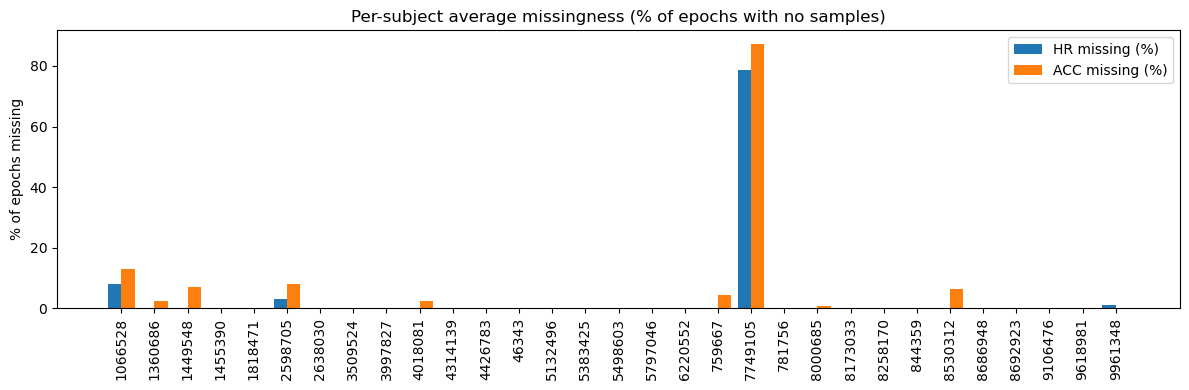

In [5]:
miss = (
    epoch_features.groupby("subject_id")
    .agg(
        hr_missing_pct=("hr_count", lambda s: 100.0 * (s == 0).mean()),
        acc_missing_pct=("acc_mag_count", lambda s: 100.0 * (s == 0).mean()),
        n_epochs=("epoch_id", "size"),
    )
    .reset_index()
    .sort_values("subject_id")
)

x = np.arange(len(miss))
width = 0.4

plt.figure(figsize=(12, 4))
plt.bar(x - width/2, miss["hr_missing_pct"], width, label="HR missing (%)")
plt.bar(x + width/2, miss["acc_missing_pct"], width, label="ACC missing (%)")

plt.xticks(x, miss["subject_id"], rotation=90)
plt.ylabel("% of epochs missing")
plt.title("Per-subject average missingness (% of epochs with no samples)")
plt.legend()
plt.tight_layout()
plt.show()

### 4.4 Causal history features (past-only rolling summaries)

Sleep is a continuous process, so we add lightweight **history context** to each epoch using only **past information**.

For each subject, we compute histiry (rolling means) for the main **level** and **variability** signals **`hr_mean`, `hr_std`, `acc_mag_mean`, `acc_mag_std`**, over the previous:   
- **5 epochs** (~2.5 minutes)   
- **20 epochs** (~10 minutes)   

To keep this strictly causal, we use `shift(1)` so the rolling window for epoch *t* uses epochs `< t` only.

In [6]:
# Make sure epochs are in time order within each subject
epoch_features = epoch_features.sort_values(["subject_id", "t_start_sec"]).reset_index(drop=True)

HISTORY_WINDOWS = [5, 20]
BASE_FOR_HISTORY = ["hr_mean", "hr_std", "acc_mag_mean", "acc_mag_std"]

for w in HISTORY_WINDOWS:
    for col in BASE_FOR_HISTORY:
        new_col = f"{col}_roll{w}"
        epoch_features[new_col] = (
            epoch_features.groupby("subject_id")[col]
            .transform(lambda s: s.shift(1).rolling(window=w, min_periods=1).mean())
        )

print("Added history features:", [c for c in epoch_features.columns if "roll" in c])
print("epoch_features shape with history features:", epoch_features.shape)
display(epoch_features.head())

Added history features: ['hr_mean_roll5', 'hr_std_roll5', 'acc_mag_mean_roll5', 'acc_mag_std_roll5', 'hr_mean_roll20', 'hr_std_roll20', 'acc_mag_mean_roll20', 'acc_mag_std_roll20']
epoch_features shape with history features: (26417, 30)


,subject_id,epoch_id,t_start_sec,t_end_sec,stage_code,time_since_start_hours,hr_mean,hr_std,hr_iqr,hr_min,...,acc_mag_max,acc_mag_diff_std,hr_mean_roll5,hr_std_roll5,acc_mag_mean_roll5,acc_mag_std_roll5,hr_mean_roll20,hr_std_roll20,acc_mag_mean_roll20,acc_mag_std_roll20
0,1066528,0,0.0,30.0,0,0.000000,52.166667,0.897527,0.0,51.0,...,1.017645,0.002779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1066528,11,30.0,60.0,0,0.008333,50.833333,1.950783,4.0,49.0,...,1.004546,0.001883,52.166667,0.897527,1.000029,0.001947,52.166667,0.897527,1.000029,0.001947
2,1066528,22,60.0,90.0,0,0.016667,52.400000,1.356466,1.0,50.0,...,1.005295,0.001951,51.500000,1.424155,1.000041,0.001725,51.500000,1.424155,1.000041,0.001725
3,1066528,33,90.0,120.0,0,0.025000,53.833333,0.372678,0.0,53.0,...,1.008659,0.002374,51.800000,1.401592,1.000067,0.001666,51.800000,1.401592,1.000067,0.001666
4,1066528,44,120.0,150.0,0,0.033333,60.500000,4.500000,8.0,56.0,...,1.006992,0.002160,52.308333,1.144364,1.000057,0.001751,52.308333,1.144364,1.000057,0.001751


### 4.5 Feature relevance and visualization

Before modeling, we do two quick sanity checks:

1) **Univariate feature relevance (ANOVA F-score)**: how strongly each feature differs across sleep stages (one feature at a time).  
2) **Single-subject timeline**: how a couple of key features evolve over time alongside the PSG stage labels.

These visualizations are descriptive (not “proof” of separability) and help validate the pipeline before ML.


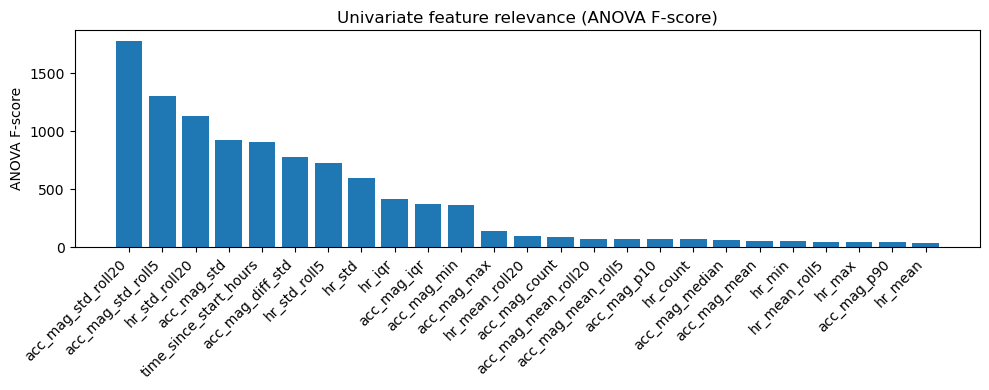

,feature,F_score,p_value
24,acc_mag_std_roll20,1781.548135,0.000000e+00
23,acc_mag_std_roll5,1300.868806,0.000000e+00
20,hr_std_roll20,1136.074761,0.000000e+00
7,acc_mag_std,926.236595,0.000000e+00
16,time_since_start_hours,909.576551,0.000000e+00
14,acc_mag_diff_std,781.981964,0.000000e+00
19,hr_std_roll5,727.759319,0.000000e+00
1,hr_std,595.518177,0.000000e+00
2,hr_iqr,420.137748,0.000000e+00
9,acc_mag_iqr,375.699593,2.950669e-315


In [7]:
from sklearn.feature_selection import f_classif

FEATURE_COLS = [
    # HR
    "hr_mean", "hr_std", "hr_iqr", "hr_min", "hr_max", "hr_count",
    # ACC magnitude
    "acc_mag_mean", "acc_mag_std", "acc_mag_median", "acc_mag_iqr",
    "acc_mag_p10", "acc_mag_p90", "acc_mag_min", "acc_mag_max",
    "acc_mag_diff_std", "acc_mag_count",
    # Time
    "time_since_start_hours",
    # Causal history (rolling means over past epochs)
    "hr_mean_roll5", "hr_mean_roll20",
    "hr_std_roll5", "hr_std_roll20",
    "acc_mag_mean_roll5", "acc_mag_mean_roll20",
    "acc_mag_std_roll5", "acc_mag_std_roll20",
]

df = epoch_features[["stage_code"] + FEATURE_COLS].copy()

# f_classif needs finite X and y; keep it simple: fill NaNs with 0 for this diagnostic
X = df[FEATURE_COLS].fillna(0.0).to_numpy()
y = df["stage_code"].to_numpy()

F, p = f_classif(X, y)
anova = pd.DataFrame({"feature": FEATURE_COLS, "F_score": F, "p_value": p}).sort_values("F_score", ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(anova["feature"], anova["F_score"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("ANOVA F-score")
plt.title("Univariate feature relevance (ANOVA F-score)")
plt.tight_layout()
plt.show()

display(anova)

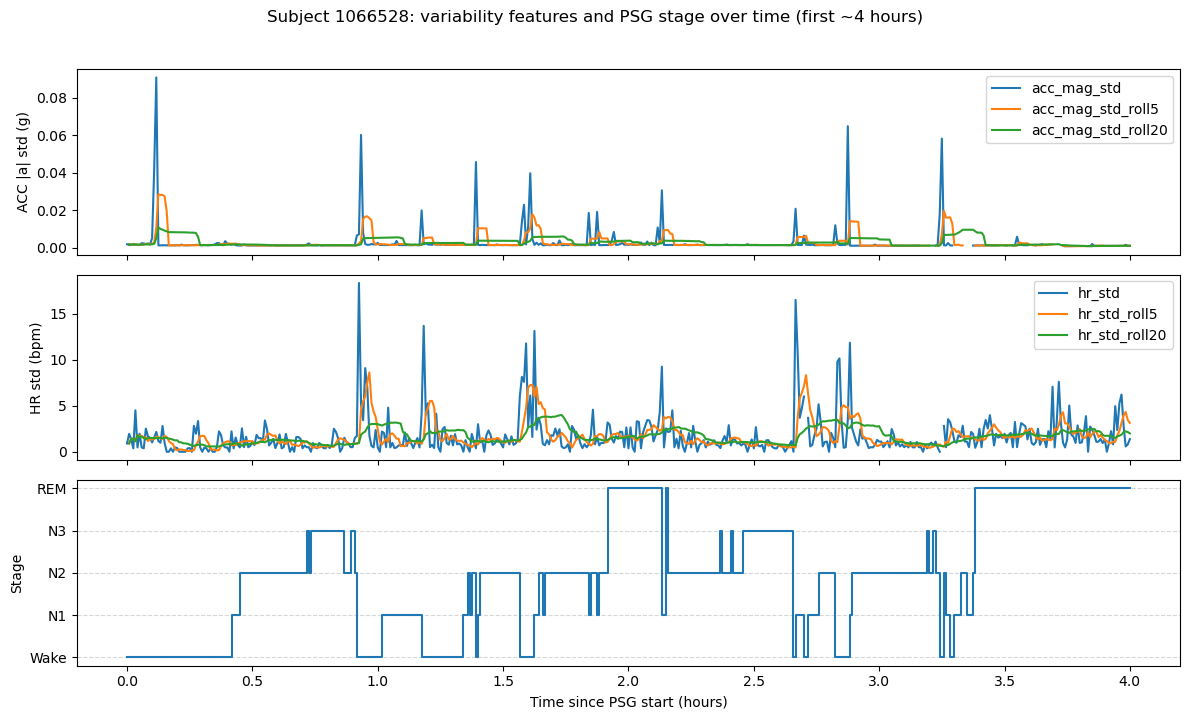

In [8]:
sid0 = SUBJECT_IDS[0]
sub = epoch_features[epoch_features["subject_id"] == sid0].sort_values("t_start_sec")

# short window for readability (first ~4 hours)
sub_win = sub[sub["t_start_sec"] <= sub["t_start_sec"].min() + 4*3600].copy()
sub_win = sub_win.set_index("t_start_sec")
sub_win.index = sub_win.index / 3600.0

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

# 1) ACC variability (std) + history
sub_win[["acc_mag_std", "acc_mag_std_roll5", "acc_mag_std_roll20"]].plot(ax=axes[0])
axes[0].set_ylabel("ACC |a| std (g)")
axes[0].legend(loc="upper right")

# 2) HR variability (std) + history
sub_win[["hr_std", "hr_std_roll5", "hr_std_roll20"]].plot(ax=axes[1])
axes[1].set_ylabel("HR std (bpm)")
axes[1].legend(loc="upper right")

# 3) Stage (names, not codes)
stage_names = sub_win["stage_code"].map(STAGE_MAP)
stage_cat = pd.Categorical(stage_names, categories=list(STAGE_MAP.values()), ordered=False)
stage_y = stage_cat.codes  # -1 should not occur if all stages are mapped

axes[2].step(sub_win.index, stage_y, where="post")
axes[2].set_ylabel("Stage")
axes[2].set_yticks(np.arange(len(stage_cat.categories)))
axes[2].set_yticklabels(stage_cat.categories)
axes[2].set_xlabel("Time since PSG start (hours)")
axes[2].grid(True, axis="y", linestyle="--", alpha=0.5)

fig.suptitle(f"Subject {sid0}: variability features and PSG stage over time (first ~4 hours)", y=1.02)
plt.tight_layout()
plt.show()

## 5. Modeling

We evaluate two label granularities using **subject-wise 5-fold GroupKFold** (leakage-aware sleep staging using the PSG-aligned epoch table):

**Target**   
- **5-class:** Wake / N1 / N2 / N3 / REM  
- **3-class:** Wake / NREM (N1+N2+N3) / REM  

**Features** per-epoch summaries + causal history features (past-only rolling means).

**Validation** **subject-wise 5-fold GroupKFold** (`group = subject_id`) to avoid subject leakage.   

**Models (no tuning):**  
- **Logistic Regression (L2, class_weight="balanced")** (baseline)   
- **HistGradientBoostingClassifier** (strong classical baseline)   

We also inspect the **label distribution** to understand class imbalance.


In [9]:
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, balanced_accuracy_score

RANDOM_STATE = 42
N_SPLITS = 5

# -----------------------------
# 1) ML arrays
# -----------------------------
FEATURE_COLS = [
    # HR
    "hr_mean", "hr_std", "hr_iqr", "hr_min", "hr_max", "hr_count",
    # ACC magnitude
    "acc_mag_mean", "acc_mag_std", "acc_mag_median", "acc_mag_iqr",
    "acc_mag_p10", "acc_mag_p90", "acc_mag_min", "acc_mag_max",
    "acc_mag_diff_std", "acc_mag_count",
    # Time
    "time_since_start_hours",
    # Causal history (rolling means over past epochs)
    "hr_mean_roll5", "hr_mean_roll20",
    "hr_std_roll5", "hr_std_roll20",
    "acc_mag_mean_roll5", "acc_mag_mean_roll20",
    "acc_mag_std_roll5", "acc_mag_std_roll20",
]

df_ml = epoch_features[["subject_id", "t_start_sec", "stage_code"] + FEATURE_COLS].copy()

X = df_ml[FEATURE_COLS].to_numpy()
y5 = df_ml["stage_code"].astype(int).to_numpy()
groups = df_ml["subject_id"].to_numpy()
# Keep epoch start time so we can later sort OOF predictions chronologically per subject (needed for causal temporal smoothing/hysteresis).
t_start = df_ml["t_start_sec"].to_numpy()

# 3-class: 0->Wake, 5->REM, {1,2,3}->NREM
y3 = np.where(y5 == 0, 0, np.where(y5 == 5, 2, 1))
STAGE3_MAP = {0: "Wake", 1: "NREM", 2: "REM"}

# -----------------------------
# 2) Pipelines (no tuning)
# -----------------------------
pipelines = {
    "LR (L2, balanced)": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            max_iter=2000,
            class_weight="balanced",
            random_state=RANDOM_STATE,
        )),
    ]),
    "HGB": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE)),
    ]),
}

# -----------------------------
# 3) Subject-wise CV splits (GroupKFold with shuffle)
# -----------------------------
cv = GroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(cv.split(X, y5, groups))

# -----------------------------
# 4) Run block helper (keeps code DRY)
# -----------------------------
def run_cv(run_name, y_run, stage_map):
    all_labels = np.sort(np.unique(y_run))
    first_model = list(pipelines.keys())[0]

    fold_scores = []
    fold_label_rows = []

    oof = {
        name: {"y_true": [], "y_pred": [], "y_proba": [], "groups": [], "t_start_sec": [], "fold": []}
        for name in pipelines
    }

    for model_name, pipe in pipelines.items():
        for f, (tr_idx, te_idx) in enumerate(tqdm(splits, desc=f"{run_name} | CV: {model_name}")):
            X_tr, X_te = X[tr_idx], X[te_idx]
            y_tr, y_te = y_run[tr_idx], y_run[te_idx]

            # Track TEST-fold label distribution once (avoid duplicates across models)
            if model_name == first_model:
                counts = pd.Series(y_te).value_counts().reindex(all_labels, fill_value=0)
                fold_label_rows.append({
                    "fold": f,
                    **{stage_map.get(int(l), str(int(l))): int(counts.loc[l]) for l in all_labels},
                    "n_test_epochs": int(len(te_idx)),
                    "n_test_subjects": int(len(np.unique(groups[te_idx]))),
                })

            pipe.fit(X_tr, y_tr)
            y_pred = pipe.predict(X_te)
            y_proba = pipe.predict_proba(X_te)

            # store OOF (needed for later)
            oof[model_name]["y_true"].append(y_te)
            oof[model_name]["y_pred"].append(y_pred)
            oof[model_name]["y_proba"].append(y_proba)
            oof[model_name]["groups"].append(groups[te_idx])
            oof[model_name]["t_start_sec"].append(t_start[te_idx])
            oof[model_name]["fold"].append(np.full(len(te_idx), f, dtype=int))

            fold_scores.append({
                "run": run_name,
                "model": model_name,
                "fold": f,
                "macro_f1": f1_score(y_te, y_pred, average="macro", labels=all_labels, zero_division=0),
                "bal_acc": balanced_accuracy_score(y_te, y_pred),
            })

    # concat OOF arrays
    for model_name in oof:
        oof[model_name]["y_true"] = np.concatenate(oof[model_name]["y_true"])
        oof[model_name]["y_pred"] = np.concatenate(oof[model_name]["y_pred"])
        oof[model_name]["y_proba"] = np.vstack(oof[model_name]["y_proba"])
        oof[model_name]["groups"] = np.concatenate(oof[model_name]["groups"])
        oof[model_name]["t_start_sec"] = np.concatenate(oof[model_name]["t_start_sec"])
        oof[model_name]["fold"] = np.concatenate(oof[model_name]["fold"])

    # fold label distribution (%)
    fold_label_counts = pd.DataFrame(fold_label_rows).sort_values("fold")
    class_cols = [c for c in fold_label_counts.columns if c not in ["fold", "n_test_epochs", "n_test_subjects"]]
    fold_label_pct = fold_label_counts.copy()
    fold_label_pct[class_cols] = (fold_label_pct[class_cols].div(fold_label_pct[class_cols].sum(axis=1), axis=0) * 100.0).round(2)

    # fold scores + summary (in %)
    df_fold_scores = pd.DataFrame(fold_scores)
    summary = (
        df_fold_scores.groupby(["run", "model"])
        .agg(
            macro_f1_mean=("macro_f1", "mean"),
            macro_f1_std=("macro_f1", lambda s: s.std(ddof=1)),
            bal_acc_mean=("bal_acc", "mean"),
            bal_acc_std=("bal_acc", lambda s: s.std(ddof=1)),
        )
        .reset_index()
    )
    for c in ["macro_f1_mean", "macro_f1_std", "bal_acc_mean", "bal_acc_std"]:
        summary[c] = (summary[c] * 100.0).round(2)
    summary = summary.sort_values("macro_f1_mean", ascending=False)

    return fold_label_pct, df_fold_scores, summary, oof

# -----------------------------
# 5) 5-class run
# -----------------------------
fold_label_pct_5c, fold_scores_5c, summary_5c, oof_5c = run_cv("5-class", y5, STAGE_MAP)

print("5-class | Test-fold label distribution (% within each test fold):")
display(fold_label_pct_5c)

print("5-class | CV summary (mean ± std over folds, in %):")
display(summary_5c)

# -----------------------------
# 6) 3-class run
# -----------------------------
fold_label_pct_3c, fold_scores_3c, summary_3c, oof_3c = run_cv("3-class", y3, STAGE3_MAP)

print("3-class | Test-fold label distribution (% within each test fold):")
display(fold_label_pct_3c)

print("3-class | CV summary (mean ± std over folds, in %):")
display(summary_3c)

# Saved for Sections 6 & 7:
# - 5-class: fold_label_pct_5c, fold_scores_5c, summary_5c, oof_5c
# - 3-class: fold_label_pct_3c, fold_scores_3c, summary_3c, oof_3c


5-class | CV: LR (L2, balanced): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.37it/s]
5-class | CV: HGB: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]

5-class | Test-fold label distribution (% within each test fold):


,fold,Wake,N1,N2,N3,REM,n_test_epochs,n_test_subjects
0,0,9.82,6.70,47.28,13.97,22.22,5854,7
1,1,8.98,6.72,46.31,14.37,23.62,5254,6
2,2,8.23,6.59,48.17,14.06,22.94,5248,6
3,3,6.70,8.98,52.37,8.43,23.52,5043,6
4,4,12.20,5.52,51.49,11.82,18.97,5018,6


5-class | CV summary (mean ± std over folds, in %):


,run,model,macro_f1_mean,macro_f1_std,bal_acc_mean,bal_acc_std
1,5-class,"LR (L2, balanced)",44.19,4.64,50.96,5.59
0,5-class,HGB,43.62,4.54,42.40,4.76


3-class | CV: LR (L2, balanced): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.75it/s]
3-class | CV: HGB: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

3-class | Test-fold label distribution (% within each test fold):


,fold,Wake,NREM,REM,n_test_epochs,n_test_subjects
0,0,9.82,67.95,22.22,5854,7
1,1,8.98,67.40,23.62,5254,6
2,2,8.23,68.83,22.94,5248,6
3,3,6.70,69.78,23.52,5043,6
4,4,12.20,68.83,18.97,5018,6


3-class | CV summary (mean ± std over folds, in %):


,run,model,macro_f1_mean,macro_f1_std,bal_acc_mean,bal_acc_std
0,3-class,HGB,55.71,4.60,54.12,4.37
1,3-class,"LR (L2, balanced)",54.73,4.89,61.06,6.75
